In [1]:
# MTREND

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

In [2]:
pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

In [3]:
import sys

sys.path.append("..")
from tooling.enums import AssetClass, Index, Spot, StrikeSpread
from tooling.fetch import fetch_option_data, fetch_spot_data
from tooling.filter import find_atm, option_tool

In [4]:
def get_expiry(f_today):
    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [5]:
bnf_pandas = pd.read_csv("../data/nifty_min (2).csv")

# INDEX = 'MIDCP'
# INDEX = 'BNF'
INDEX = 'NIFTY'
# INDEX = 'FNF'
# INDEX = 'STOCK'
# INDEX = 'SENSEX'

# lev_ = 1
INDEX_ = INDEX

if INDEX == 'BNF':
    lev_ = 6
    # lev_ = 4
    slippage_ = 0.0001
    lot_size_ = 30
    sma_ = 48
    tma_ = 18
    candles_ = 1
elif INDEX == 'NIFTY':
    lev_ = 7.5
    # lev_ = 5
    slippage_ = 0.0002
    lot_size_ = 75
    sma_ = 32
    tma_ = 40
    candles_ = 1
elif INDEX == 'MIDCP':
    lev_ = 4.5
    # lev_ = 5
    slippage_ = 0.0005
    lot_size_ = 120
    sma_ = 9
    tma_ = 68
    candles_ = 1
elif INDEX == 'SENSEX':
    lev_ = 7.5
    # lev_ = 5
    slippage_ = 0.0001
    lot_size_ = 20
    sma_ = 45
    tma_ = 16
    candles_ = 1
elif INDEX == 'STOCK':
    lev_ = 5
    slippage_ = 0.001
    lot_size_ = 1
# bnf_pandas = pd.read_csv("../data/finnifty_1hr_tv (2).csv")
# bnf_pandas = pd.read_csv('../data/midcp_1hr_tv (4).csv')
# bnf_pandas = pd.read_csv('../data/finnifty_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/bnf_fut_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/gold_4hr_tv.csv')


In [6]:
bnf_pandas['datetime'] = pd.to_datetime(bnf_pandas['datetime'])
bnf_pandas = bnf_pandas[bnf_pandas['datetime'].dt.time <= dt.time(15, 29)]
bnf_pandas.head()

index            datetime      open      high       low     close  volume
0  nifty 2017-01-02 09:15:00 8210.1000 8211.7000 8189.0000 8189.5500       0
1  nifty 2017-01-02 09:16:00 8188.7500 8193.9500 8188.7500 8189.9500       0
2  nifty 2017-01-02 09:17:00 8190.1500 8190.7500 8173.7000 8173.7000       0
3  nifty 2017-01-02 09:18:00 8173.3500 8177.5500 8169.1500 8177.5500       0
4  nifty 2017-01-02 09:19:00 8177.8500 8178.1500 8173.4500 8174.4000       0

In [7]:
def parse_timeframe(timeframe: str) -> pl.duration:
    if timeframe.endswith('m'):
        return pl.duration(minutes=int(timeframe[:-1]))
    elif timeframe.endswith('h'):
        return pl.duration(hours=int(timeframe[:-1]))
    # Add more cases if needed
    else:
        raise ValueError(f"Unknown timeframe format: {timeframe}")

def resample(data: pl.DataFrame, timeframe: str, offset: str = '0m') -> pl.DataFrame:
    # data = data.with_columns(
    #     pl.col("datetime").str.strptime(pl.Datetime, strict=False)   # <-- fix here
    # )
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(
            [
                pl.col("open").first().alias("open"),
                pl.col("high").max().alias("high"),
                pl.col("low").min().alias("low"),
                pl.col("close").last().alias("close"),
                pl.col("volume").sum().alias("volume"),
            ]
        )
    )


In [8]:
bnf = pl.DataFrame(bnf_pandas)
bnf_1hr = resample(bnf, '60m', '15m')   # offset can be '0m' if you want no offset
bnf = bnf_1hr

In [9]:
bnf.tail(100)

shape: (100, 6)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┬────────┐
│ datetime            ┆ open     ┆ high     ┆ low      ┆ close    ┆ volume │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---    │
│ datetime[ns]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ i64    │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╪════════╡
│ 2025-05-12 14:15:00 ┆ 24866.25 ┆ 24930.4  ┆ 24854.75 ┆ 24907.45 ┆ 0      │
│ 2025-05-12 15:15:00 ┆ 24907.45 ┆ 24944.8  ┆ 24904.75 ┆ 24920.25 ┆ 0      │
│ 2025-05-13 09:15:00 ┆ 24864.05 ┆ 24973.8  ┆ 24675.6  ┆ 24770.85 ┆ 0      │
│ 2025-05-13 10:15:00 ┆ 24771.1  ┆ 24837.8  ┆ 24634.9  ┆ 24724.55 ┆ 0      │
│ 2025-05-13 11:15:00 ┆ 24725.05 ┆ 24817.9  ┆ 24693.9  ┆ 24755.45 ┆ 0      │
│ 2025-05-13 12:15:00 ┆ 24755.55 ┆ 24772.0  ┆ 24597.6  ┆ 24630.8  ┆ 0      │
│ 2025-05-13 13:15:00 ┆ 24633.4  ┆ 24637.0  ┆ 24576.0  ┆ 24590.45 ┆ 0      │
│ 2025-05-13 14:15:00 ┆ 24590.25 ┆ 24636.85 ┆ 24559.15 ┆ 24560.0  ┆ 0      │
│ 2025-05-13 15:15:00 ┆ 24561.05 ┆ 24594.3  ┆ 24547.5  ┆ 24593.65 ┆ 0      │
│ 2025-05-14 09:15:00 ┆ 24613.8  ┆ 24758.55 ┆ 24581.75 ┆ 24758.15 ┆ 0      │
│ 2025-05-14 10:15:00 ┆ 24757.4  ┆ 24767.55 ┆ 24683.45 ┆ 24700.95 ┆ 0      │
│ 2025-05-14 11:15:00 ┆ 24699.65 ┆ 24724.9  ┆ 24633.05 ┆ 24677.1  ┆ 0      │
│ 2025-05-14 12:15:00 ┆ 24677.25 ┆ 24679.65 ┆ 24535.55 ┆ 24636.05 ┆ 0      │
│ 2025-05-14 13:15:00 ┆ 24636.45 ┆ 24660.95 ┆ 24596.75 ┆ 24615.0  ┆ 0      │
│ 2025-05-14 14:15:00 ┆ 24614.55 ┆ 24675.2  ┆ 24577.7  ┆ 24669.55 ┆ 0      │
│ 2025-05-14 15:15:00 ┆ 24669.55 ┆ 24696.75 ┆ 24651.3  ┆ 24685.75 ┆ 0      │
│ 2025-05-15 09:15:00 ┆ 24694.45 ┆ 24706.75 ┆ 24494.45 ┆ 24561.7  ┆ 0      │
│ 2025-05-15 10:15:00 ┆ 24562.2  ┆ 24807.75 ┆ 24533.2  ┆ 24617.25 ┆ 0      │
│ 2025-05-15 11:15:00 ┆ 24617.25 ┆ 24707.9  ┆ 24601.15 ┆ 24661.05 ┆ 0      │
│ 2025-05-15 12:15:00 ┆ 24662.05 ┆ 24888.9  ┆ 24626.3  ┆ 24886.3  ┆ 0      │
│ 2025-05-15 13:15:00 ┆ 24887.15 ┆ 25106.05 ┆ 24848.8  ┆ 25091.0  ┆ 0      │
│ 2025-05-15 14:15:00 ┆ 25091.5  ┆ 25116.25 ┆ 25040.0  ┆ 25056.4  ┆ 0      │
│ 2025-05-15 15:15:00 ┆ 25055.2  ┆ 25063.45 ┆ 25035.3  ┆ 25035.3  ┆ 0      │
│ 2025-05-16 09:15:00 ┆ 25064.65 ┆ 25070.0  ┆ 24975.8  ┆ 25005.15 ┆ 0      │
│ 2025-05-16 10:15:00 ┆ 25005.65 ┆ 25040.85 ┆ 24953.05 ┆ 24975.45 ┆ 0      │
│ 2025-05-16 11:15:00 ┆ 24975.15 ┆ 24997.9  ┆ 24958.7  ┆ 24976.05 ┆ 0      │
│ 2025-05-16 12:15:00 ┆ 24974.65 ┆ 25018.5  ┆ 24968.8  ┆ 25006.8  ┆ 0      │
│ 2025-05-16 13:15:00 ┆ 25006.75 ┆ 25034.8  ┆ 24994.45 ┆ 25019.95 ┆ 0      │
│ 2025-05-16 14:15:00 ┆ 25019.6  ┆ 25034.5  ┆ 24992.35 ┆ 25024.2  ┆ 0      │
│ 2025-05-16 15:15:00 ┆ 25025.45 ┆ 25025.6  ┆ 25002.7  ┆ 25013.1  ┆ 0      │
│ 2025-05-19 09:15:00 ┆ 25005.35 ┆ 25058.7  ┆ 24965.8  ┆ 25040.85 ┆ 0      │
│ 2025-05-19 10:15:00 ┆ 25040.2  ┆ 25062.95 ┆ 24999.45 ┆ 25027.05 ┆ 0      │
│ 2025-05-19 11:15:00 ┆ 25026.55 ┆ 25043.1  ┆ 24979.1  ┆ 24987.5  ┆ 0      │
│ 2025-05-19 12:15:00 ┆ 24987.4  ┆ 25018.6  ┆ 24972.25 ┆ 24980.55 ┆ 0      │
│ 2025-05-19 13:15:00 ┆ 24980.45 ┆ 25006.1  ┆ 24919.3  ┆ 24940.35 ┆ 0      │
│ 2025-05-19 14:15:00 ┆ 24940.2  ┆ 24960.55 ┆ 24916.65 ┆ 24945.65 ┆ 0      │
│ 2025-05-19 15:15:00 ┆ 24945.35 ┆ 24951.65 ┆ 24927.45 ┆ 24935.35 ┆ 0      │
│ 2025-05-20 09:15:00 ┆ 24996.2  ┆ 25010.35 ┆ 24863.4  ┆ 24899.4  ┆ 0      │
│ 2025-05-20 10:15:00 ┆ 24899.5  ┆ 24967.25 ┆ 24879.0  ┆ 24920.75 ┆ 0      │
│ 2025-05-20 11:15:00 ┆ 24921.05 ┆ 24921.05 ┆ 24844.55 ┆ 24859.2  ┆ 0      │
│ 2025-05-20 12:15:00 ┆ 24862.0  ┆ 24876.2  ┆ 24780.65 ┆ 24790.7  ┆ 0      │
│ 2025-05-20 13:15:00 ┆ 24790.45 ┆ 24795.1  ┆ 24728.1  ┆ 24738.35 ┆ 0      │
│ 2025-05-20 14:15:00 ┆ 24737.1  ┆ 24745.6  ┆ 24669.7  ┆ 24693.1  ┆ 0      │
│ 2025-05-20 15:15:00 ┆ 24693.1  ┆ 24713.85 ┆ 24672.05 ┆ 24713.85 ┆ 0      │
│ 2025-05-21 09:15:00 ┆ 24744.25 ┆ 24870.2  ┆ 24692.65 ┆ 24869.2  ┆ 0      │
│ 2025-05-21 10:15:00 ┆ 24869.85 ┆ 24946.2  ┆ 24858.05 ┆ 24896.95 ┆ 0      │
│ 2025-05-21 11:15:00 ┆ 24896.3  ┆ 24914.4  ┆ 24727.1  ┆ 

In [10]:
def generate_signals1(df, signal_ma, trailing_ma, candles_in_num):
    df["c"] = pd.to_numeric(df["c"], errors="coerce")
    df["MA20"] = df["c"].rolling(window=signal_ma).mean()
    df["MA10"] = df["c"].rolling(window=trailing_ma).mean()

    df["Buy_Signal"] = 0

    # Generate signals using boolean masking
    buy_signal_mask = df["MA20"] > df["MA20"].shift(1)
    
    for i in range(1, candles_in_num):
        buy_signal_mask &= df["MA20"].shift(i) > df["MA20"].shift(i + 1)

    df.loc[buy_signal_mask, "Buy_Signal"] = 1

    return df

In [11]:
def generate_signals2(df, i, j, candles_in_num):
    df["c"] = pd.to_numeric(df["c"], errors="coerce")
    df["MA20"] = df["c"].rolling(window=i).mean()
    df["MA10"] = df["c"].rolling(window=j).mean()

    df["Sell_Signal"] = 0

    # Generate signals using boolean masking
    sell_signal_mask = df["MA20"] < df["MA20"].shift(1)

    for i in range(1, candles_in_num):
        sell_signal_mask &= df["MA20"].shift(i) < df["MA20"].shift(i + 1)

    df.loc[sell_signal_mask, "Sell_Signal"] = 1

    return df

In [12]:
# # Positional

# def execute(df):

#     trade_book = []
#     in_trade = False
#     signal_entry_price = 100000
#     signal_initial_sl = 0
#     already_signal_exists = False
#     is_trailing_active = False
#     remark = ""
#     portfolio_value = 6250000
#     previous_trade_exit_time = None

#     for i in range(1, len(df)):
#         points = 0
#         current_candle_open = df.iloc[i]["o"]
#         current_candle_high = df.iloc[i]["h"]
#         current_candle_low = df.iloc[i]["l"]
#         current_candle_close = df.iloc[i]["c"]
#         current_candle_datetime = df.iloc[i]['datetime']
#         current_moving_average_price = df.iloc[i]["MA10"]

#         if not in_trade:
#             if df.iloc[i]["Buy_Signal"] == 1 and current_candle_datetime.time() < dt.time(15, 15):
#                 if not already_signal_exists:
#                     # Fresh Buy Signal
#                     # print(df.iloc[i])
#                     # print('Fresh Buy Signal')
#                     signal_entry_price = current_candle_high
#                     signal_initial_sl = current_candle_low
#                     signal_creation_time = df.iloc[i]["datetime"]
#                     already_signal_exists = True

#                     # if (signal_entry_price - signal_initial_sl > 400):
#                     #     # Skip Signal Candle Due To Big Size
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0

#                 else:
#                     # if current_candle_open > signal_entry_price:
#                     #     # Gap Up Open, SKIP trade
#                     #     # print(df.iloc[i])
#                     #     # print('Gap Up Open, Skip Trade')
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0
                    
#                     if current_candle_high < signal_entry_price:
#                         # Better Candle
#                         # print(df.iloc[i])
#                         # print('Better Candle')
#                         signal_entry_price = current_candle_high
#                         signal_initial_sl = current_candle_low
#                         signal_creation_time = df.iloc[i]["datetime"]

#                         # if (signal_entry_price - signal_initial_sl > 400):
#                         #     # Skip Signal Candle Due To Big Size
#                         #     already_signal_exists = False
#                         #     signal_entry_price = 100000
#                         #     signal_initial_sl = 0

#                     elif current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
#                         # Entry Triggered
#                         # print(df.iloc[i])
#                         # print('Entry Triggered')
#                         in_trade = True
#                         entry_time = df.iloc[i]["datetime"]
#                         entry_price = signal_entry_price
#                         points = 0
#             else:
#                 if df.iloc[i - 1]["Buy_Signal"] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
#                     # Considering the forward bias condition as well now
#                     signal_entry_price = df.iloc[i - 1]["h"]
#                     signal_initial_sl = df.iloc[i - 1]["l"]
#                     signal_creation_time = df.iloc[i - 1]["datetime"]
#                     already_signal_exists = True

#                     # if current_candle_open > signal_entry_price:
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0

#                     if current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
#                         if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
#                             in_trade = True
#                             entry_time = df.iloc[i]["datetime"]
#                             entry_price = signal_entry_price
#                             points = 0
#                     else:
#                         # Discard Existing Signal
#                         already_signal_exists = False
#                         signal_entry_price = 100000
#                         signal_initial_sl = 0

#             # if df.iloc[i-1]["Buy_Signal"] == 1:
#             #     signal_entry_price = df.iloc[i-1]['h']
#             #     signal_initial_sl = df.iloc[i-1]['l']
#             #     signal_creation_time = df.iloc[i-1]["datetime"]

#             #     if current_candle_open > signal_entry_price:
#             #         # Gap Up Open, SKIP trade
#             #         already_signal_exists = False
#             #         signal_entry_price = 100000
#             #         signal_initial_sl = 0
                
#             #     elif current_candle_high >= signal_entry_price:
#             #         # Entry Triggered
#             #         in_trade = True
#             #         entry_time = df.iloc[i]["datetime"]
#             #         entry_price = signal_entry_price
#             #         points = 0

#         if in_trade:
#             trade_entry_price = signal_entry_price
#             trade_initial_sl = signal_initial_sl
#             trade_final_sl = signal_initial_sl

#             if (
#                 not is_trailing_active
#                 and current_candle_low > current_moving_average_price
#             ):
#                 is_trailing_active = True

#             if not is_trailing_active:
#                 if current_candle_open < trade_initial_sl:
#                     # if df.iloc[i-1]['l'] < trade_initial_sl:
#                     #     #Previous Candle Already Hit the SL Hence don't check gap down
#                     #     print(df.iloc[i])
#                     #     print('Initial SL Hit Before Gap Down')
#                     #     in_trade = False
#                     #     points = trade_initial_sl - trade_entry_price
#                     #     exit_price = trade_initial_sl
#                     #     exit_time = df.iloc[i-1]['datetime']
#                     #     remark = 'Initial SL Hit Before Gap Down'
#                     # else:
#                     if (
#                         df.iloc[i]["datetime"].date() == entry_time.date()
#                         and df.iloc[i]["datetime"].time() == entry_time.time()
#                     ):
#                         if current_candle_close <= trade_initial_sl:
#                             in_trade = False
#                             points = trade_initial_sl - trade_entry_price
#                             exit_price = trade_initial_sl
#                             exit_time = df.iloc[i]["datetime"]
#                             remark = "Initial SL hit"

#                     else:
#                         # Gap Open Outside ISL
#                         # print(df.iloc[i])
#                         # print('Gap Open Outside ISL')
#                         in_trade = False
#                         points = current_candle_open - trade_entry_price
#                         exit_price = current_candle_open
#                         exit_time = df.iloc[i]["datetime"]
#                         remark = "Gap Open Outside ISL"

#                 elif current_candle_low <= trade_initial_sl:
#                     # Initial SL Hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = trade_initial_sl - trade_entry_price
#                     exit_price = trade_initial_sl
#                     exit_time = df.iloc[i]["datetime"]
#                     remark = "Initial SL Hit"

#             else:
#                 trade_final_sl = max(trade_initial_sl, current_moving_average_price)

#                 if current_candle_open <= trade_initial_sl:
#                     # if df.iloc[i-1]['l'] < trade_initial_sl:
#                     #     #Previous Candle Already Hit the SL Hence don't check gap down
#                     #     print(df.iloc[i])
#                     #     print('Initial SL Hit Before Gap Down')
#                     #     in_trade = False
#                     #     points = trade_initial_sl - trade_entry_price
#                     #     exit_price = trade_initial_sl
#                     #     exit_time = df.iloc[i-1]['datetime']
#                     #     remark = 'Initial SL Hit'
#                     # else:
#                     if (
#                         df.iloc[i]["datetime"].date() == entry_time.date()
#                         and df.iloc[i]["datetime"].time() == entry_time.time()
#                     ):
#                         if current_candle_close <= trade_initial_sl:
#                             in_trade = False
#                             points = trade_initial_sl - trade_entry_price
#                             exit_price = trade_initial_sl
#                             exit_time = df.iloc[i]["datetime"]
#                             remark = "Initial SL hit"

#                     else:
#                         # Gap Open Outside ISL
#                         # print(df.iloc[i])
#                         # print('Gap Open Outside ISL')
#                         in_trade = False
#                         points = current_candle_open - trade_entry_price
#                         exit_price = current_candle_open
#                         exit_time = df.iloc[i]["datetime"]
#                         remark = "Gap Open Outside ISL"

#                 elif current_candle_low <= trade_initial_sl:
#                     # if trade_initial_sl >= current_moving_average_price:
#                     # Despite Trailing, Initial SL hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = trade_initial_sl - trade_entry_price
#                     exit_price = trade_initial_sl
#                     exit_time = df.iloc[i]["datetime"]
#                     remark = "Initial SL hit"

#                 elif current_candle_close <= trade_final_sl:
#                     # Price Closed below TSL i.e. MA10 , TSL Hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = current_candle_close - trade_entry_price
#                     exit_price = current_candle_close
#                     exit_time = df.iloc[i]["datetime"]
#                     is_trailing_active = False
#                     remark = "TSL Hit"

#             if points:
#                 index_lev = lev_
#                 qty = int(round(portfolio_value * index_lev / entry_price / lot_size_)) * lot_size_
#                 slippage = slippage_ * (entry_price + exit_price)
#                 # slippage = 10
#                 final_points = points - slippage
#                 # final_points = points
#                 previous_trade_exit_time = exit_time
#                 trade = {
#                     "Signal Generated At": signal_creation_time,
#                     "Trade Type": "LONG",
#                     "Entry Time": entry_time,
#                     "Entry Price": entry_price,
#                     "Initial SL": trade_initial_sl,
#                     "Final SL": trade_final_sl,
#                     "Exit Time": exit_time,
#                     "Exit Price": exit_price,
#                     "Points Captured": points,
#                     "After Costs": final_points,
#                     "PnL": final_points * qty,
#                     "Remarks": remark,
#                     "Qty": qty,
#                     "Leverage": index_lev,
#                     "ROI%": (final_points * qty / portfolio_value) * 100,
#                     "Trade Year": entry_time.year,
#                     "Trade Month": entry_time.month,
#                 }
#                 trade_book.append(trade)
#                 points = 0
#                 in_trade = False
#                 already_signal_exists = False
#                 remark = ""
#                 is_trailing_active = False

#     trade_book_df = pd.DataFrame(trade_book)
#     return trade_book_df

In [30]:
# Positional

def execute(df):

    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    is_trailing_active = False
    remark = ""
    portfolio_value = 3750000
    previous_trade_exit_time = None

    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_candle_datetime = df.iloc[i]['datetime']
        current_moving_average_price = df.iloc[i]["MA10"]

        if current_candle_datetime.time() == dt.time(15, 15):
            df.iloc[i]['Buy_Signal'] = 0
            # continue
        if not in_trade:
            if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
                if df.iloc[i-1]['Buy_Signal'] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
                    signal_entry_price = df.iloc[i-1]['h']
                    signal_initial_sl = df.iloc[i-1]['l']
                    signal_creation_time = df.iloc[i-1]['datetime']
                    if current_candle_high >= signal_entry_price:
                        #Entry Triggered
                        entry_price = signal_entry_price
                        entry_time = current_candle_datetime
                        in_trade = True

        # if not in_trade:
        #     if current_candle_datetime.time() == dt.time(15, 15):
        #         df.iloc[i]["Buy_Signal"] = 0
        #         continue
        #     if df.iloc[i]["Buy_Signal"] == 1 and current_candle_datetime.time() < dt.time(15, 15):
        #         if not already_signal_exists:
        #             # Fresh Buy Signal
        #             # print(df.iloc[i])
        #             # print('Fresh Buy Signal')
        #             signal_entry_price = current_candle_high
        #             signal_initial_sl = current_candle_low
        #             signal_creation_time = df.iloc[i]["datetime"]
        #             already_signal_exists = True

        #             # if (signal_entry_price - signal_initial_sl > 400):
        #             #     # Skip Signal Candle Due To Big Size
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0

        #         else:
        #             # if current_candle_open > signal_entry_price:
        #             #     # Gap Up Open, SKIP trade
        #             #     # print(df.iloc[i])
        #             #     # print('Gap Up Open, Skip Trade')
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0
                    
        #             if current_candle_high < signal_entry_price:
        #                 # Better Candle
        #                 # print(df.iloc[i])
        #                 # print('Better Candle')
        #                 signal_entry_price = current_candle_high
        #                 signal_initial_sl = current_candle_low
        #                 signal_creation_time = df.iloc[i]["datetime"]

        #                 # if (signal_entry_price - signal_initial_sl > 400):
        #                 #     # Skip Signal Candle Due To Big Size
        #                 #     already_signal_exists = False
        #                 #     signal_entry_price = 100000
        #                 #     signal_initial_sl = 0

        #             elif current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
        #                 # Entry Triggered
        #                 # print(df.iloc[i])
        #                 # print('Entry Triggered')
        #                 in_trade = True
        #                 entry_time = df.iloc[i]["datetime"]
        #                 entry_price = signal_entry_price
        #                 points = 0
        #     else:
        #         if df.iloc[i - 1]["Buy_Signal"] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
        #             # Considering the forward bias condition as well now
        #             signal_entry_price = df.iloc[i - 1]["h"]
        #             signal_initial_sl = df.iloc[i - 1]["l"]
        #             signal_creation_time = df.iloc[i - 1]["datetime"]
        #             already_signal_exists = True

        #             # if current_candle_open > signal_entry_price:
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0

        #             if current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
        #                 if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
        #                     in_trade = True
        #                     entry_time = df.iloc[i]["datetime"]
        #                     entry_price = signal_entry_price
        #                     points = 0
        #             else:
        #                 # Discard Existing Signal
        #                 already_signal_exists = False
        #                 signal_entry_price = 100000
        #                signal_initial_sl = 0

            # if df.iloc[i-1]["Buy_Signal"] == 1:
            #     signal_entry_price = df.iloc[i-1]['h']
            #     signal_initial_sl = df.iloc[i-1]['l']
            #     signal_creation_time = df.iloc[i-1]["datetime"]

            #     if current_candle_open > signal_entry_price:
            #         # Gap Up Open, SKIP trade
            #         already_signal_exists = False
            #         signal_entry_price = 100000
            #         signal_initial_sl = 0
                
            #     elif current_candle_high >= signal_entry_price:
            #         # Entry Triggered
            #         in_trade = True
            #         entry_time = df.iloc[i]["datetime"]
            #         entry_price = signal_entry_price
            #         points = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_low > current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open < trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit Before Gap Down'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # Initial SL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

            else:
                trade_final_sl = max(trade_initial_sl, current_moving_average_price)

                if current_candle_open <= trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # if trade_initial_sl >= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close <= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = current_candle_close - trade_entry_price
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                index_lev = lev_
                qty = int(round(portfolio_value * index_lev / entry_price / lot_size_)) * lot_size_
                slippage = slippage_ * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                previous_trade_exit_time = exit_time
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "LONG",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": index_lev,
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False
                i += 1

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [31]:
bnf1 = bnf
bnf2 = bnf

In [32]:
def generate_stats(tb_expiry, signal_ma, trailing_ma):
    stats_df8 = pd.DataFrame(
        index=range(2017, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2017, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f'{signal_ma} , {trailing_ma}'
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation
    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio : stats_df8}

In [33]:
bnf1 = bnf1.to_pandas()
bnf2 = bnf2.to_pandas()

In [34]:
bnf1['datetime'] = pd.to_datetime(bnf1['datetime'])
bnf2['datetime'] = pd.to_datetime(bnf2['datetime'])

In [35]:
bnf1 = bnf1[bnf1['datetime'].dt.time >= dt.time(9, 14)]
bnf1 = bnf2[bnf2['datetime'].dt.time >= dt.time(9, 14)]

In [36]:
bnf1.tail(15000)

datetime       open       high        low      close  volume
0     2017-01-02 09:15:00  8210.1000  8211.7000  8141.3500  8154.8000       0
1     2017-01-02 10:15:00  8155.1500  8161.8000  8134.3000  8146.8000       0
2     2017-01-02 11:15:00  8146.9500  8159.0500  8137.5000  8150.3000       0
3     2017-01-02 12:15:00  8150.3000  8166.5500  8144.9500  8165.3500       0
4     2017-01-02 13:15:00  8165.3500  8195.6000  8160.8000  8192.4500       0
5     2017-01-02 14:15:00  8192.0500  8201.8000  8171.6500  8178.3000       0
6     2017-01-02 15:15:00  8178.2500  8181.0000  8173.6000  8179.2000       0
7     2017-01-03 09:15:00  8195.2500  8196.0000  8148.6500  8185.5000       0
8     2017-01-03 10:15:00  8185.1500  8207.2000  8181.4000  8205.0500       0
9     2017-01-03 11:15:00  8205.0500  8214.5500  8195.1000  8206.6000       0
10    2017-01-03 12:15:00  8206.5500  8211.9500  8203.9000  8205.7500       0
11    2017-01-03 13:15:00  8206.1500  8209.1500  8178.8500  8197.2500       0
12    2017-01-03 14:15:00  8197.0500  8219.0000  8189.9000  8190.2000       0
13    2017-01-03 15:15:00  8189.7500  8195.9000  8187.0000  8189.0500       0
14    2017-01-04 09:15:00  8200.8000  8218.2500  8191.1000  8216.3500       0
15    2017-01-04 10:15:00  8216.6000  8218.4500  8192.9500  8200.4000       0
16    2017-01-04 11:15:00  8200.5000  8209.8000  8180.9500  8184.3500       0
17    2017-01-04 12:15:00  8185.2500  8203.8000  8183.0500  8199.8500       0
18    2017-01-04 13:15:00  8199.6500  8212.9000  8191.8500  8200.0000       0
19    2017-01-04 14:15:00  8200.1500  8202.0000  8182.4000  8188.4500       0
20    2017-01-04 15:15:00  8188.5500  8197.7000  8187.3500  8196.3500       0
21    2017-01-05 09:15:00  8226.6500  8251.8000  8223.9000  8242.1500       0
22    2017-01-05 10:15:00  8242.5000  8255.8500  8239.4500  8255.3500       0
23    2017-01-05 11:15:00  8255.3000  8266.8500  8252.3500  8264.3000       0
24    2017-01-05 12:15:00  8264.5000  8271.6000  8252.5000  8267.4500       0
25    2017-01-05 13:15:00  8267.5000  8278.8500  8259.4000  8266.0500       0
26    2017-01-05 14:15:00  8266.0500  8282.5500  8251.9500  8272.2500       0
27    2017-01-05 15:15:00  8272.5000  8274.6500  8267.6000  8270.5000       0
28    2017-01-06 09:15:00  8283.0000  8306.5000  8282.1500  8294.2500       0
29    2017-01-06 10:15:00  8294.0000  8294.5500  8259.5500  8260.0000       0
30    2017-01-06 11:15:00  8260.0000  8279.9500  8259.9500  8276.8500       0
31    2017-01-06 12:15:00  8276.7000  8279.1500  8259.6500  8266.2000       0
32    2017-01-06 13:15:00  8266.3500  8276.2000  8257.7500  8269.1500       0
33    2017-01-06 14:15:00  8268.7500  8276.0000  8233.4500  8242.0500       0
34    2017-01-06 15:15:00  8242.3500  8252.7000  8240.8500  8248.2000       0
35    2017-01-09 09:15:00  8259.1000  8260.3000  8233.5000  8241.7000       0
36    2017-01-09 10:15:00  8241.9000  8246.5500  8228.0000  8239.5000       0
37    2017-01-09 11:15:00  8239.7000  8250.3500  8236.9500  8246.0000       0
38    2017-01-09 12:15:00  8246.1000  8246.8500  8236.9500  8238.6000       0
39    2017-01-09 13:15:00  8238.6500  8254.5000  8236.9500  8250.3500       0
40    2017-01-09 14:15:00  8250.2500  8252.0000  8234.8000  8235.3000       0
41    2017-01-09 15:15:00  8235.4500  8237.9000  8229.6500  8234.5500       0
42    2017-01-10 09:15:00  8262.7000  8287.9500  8262.2500  8274.4500       0
43    2017-01-10 10:15:00  8274.7000  8277.8500  8263.8000  8266.1000       0
44    2017-01-10 11:15:00  8266.0000  8276.2000  8265.7000  8269.4500       0
45    2017-01-10 12:15:00  8269.5500  8274.9000  8264.2000  8274.4000       0
46    2017-01-10 13:15:00  8274.6000  8289.5000  8274.6000  8279.2500       0
47    2017-01-10 14:15:00  8278.7500  8286.4000  8272.0000  8284.6000       0
48    2017-01-10 15:15:00  8284.6000  8293.5500  8284.0500  8290.3000       0
49    2017-01-11 09:15:00  8329.8500  8345.2500  8322.5500  8338.1000       0
50    2017-01-11 10:15:00  8338.1000  8

In [37]:
# stats_dictionary = {}

# for i in range(6, 81):
#     for j in range(4, 101, 2):
#         print(f"Signal MA : {i} , Trailing MA : {j}")
#         signals_df1 = generate_signals1(bnf1, i, j)
#         signals_df1 = signals_df1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})
#         new_tb = execute(signals_df1)
#         new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
#         tradebook_buy_side = new_tb
#         stats = generate_stats(tradebook_buy_side, i, j)
#         for overall_roi_dd_ratio, stats_df in stats.items():
#             if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 10:
#                 print(stats_df.to_string())
#                 stats_dictionary[overall_roi_dd_ratio] = stats_df

In [38]:
# sorted_stats = {k: v for k, v in sorted(stats_dictionary.items(), key=lambda item: item[0], reverse=True)}
# sorted_stats

In [39]:
bnf1 = bnf1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})

In [40]:
sma = 33
tma = 16
candles = 1
variation = f'{INDEX}, {sma} , {tma} , {candles}'
signals_df1 = generate_signals1(bnf1, sma, tma, candles)

In [41]:
# signals_df2.tail(130)

In [42]:

new_tb = execute(signals_df1)
# new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
tradebook_buy_side = new_tb
# new_tb

/tmp/ipykernel_28748/3715834428.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i]['Buy_Signal'] = 0


In [43]:
# tradebook_buy_side['DD%'] = (tradebook_buy_side['ROI%'].cumsum() - tradebook_buy_side['ROI%'].cumsum().cummax())
# tradebook_buy_side

In [44]:
new_tb.tail(50)
# new_tb[new_tb['Entry Time'].dt.time == dt.time(9, 15)]

Signal Generated At Trade Type          Entry Time  Entry Price  \
649 2024-09-25 10:15:00       LONG 2024-09-25 11:15:00   25928.0500   
650 2024-09-25 12:15:00       LONG 2024-09-25 13:15:00   25899.9500   
651 2024-10-14 10:15:00       LONG 2024-10-14 11:15:00   25118.4000   
652 2024-10-16 12:15:00       LONG 2024-10-16 13:15:00   24986.3000   
653 2024-11-06 10:15:00       LONG 2024-11-06 11:15:00   24390.5500   
654 2024-11-11 09:15:00       LONG 2024-11-11 10:15:00   24178.7000   
655 2024-11-22 12:15:00       LONG 2024-11-22 13:15:00   23724.1000   
656 2024-11-27 11:15:00       LONG 2024-11-27 12:15:00   24218.8500   
657 2024-11-29 09:15:00       LONG 2024-11-29 10:15:00   24072.1500   
658 2024-12-05 10:15:00       LONG 2024-12-05 11:15:00   24441.7500   
659 2024-12-09 10:15:00       LONG 2024-12-09 11:15:00   24646.0500   
660 2024-12-10 13:15:00       LONG 2024-12-10 14:15:00   24569.9500   
661 2024-12-13 13:15:00       LONG 2024-12-13 14:15:00   24757.9000   
662 2024-12-30 10:15:00       LONG 2024-12-30 11:15:00   23844.4000   
663 2025-01-01 12:15:00       LONG 2025-01-01 13:15:00   23773.0000   
664 2025-01-07 10:15:00       LONG 2025-01-07 11:15:00   23768.0500   
665 2025-01-20 10:15:00       LONG 2025-01-20 11:15:00   23283.0500   
666 2025-01-21 12:15:00       LONG 2025-01-21 13:15:00   23294.8000   
667 2025-01-24 10:15:00       LONG 2025-01-24 11:15:00   23289.2000   
668 2025-01-28 12:15:00       LONG 2025-01-28 13:15:00   23068.9000   
669 2025-01-29 09:15:00       LONG 2025-01-29 10:15:00   23097.3000   
670 2025-02-01 13:15:00       LONG 2025-02-01 14:15:00   23533.7000   
671 2025-02-03 10:15:00       LONG 2025-02-03 11:15:00   23328.3500   
672 2025-02-06 11:15:00       LONG 2025-02-06 12:15:00   23626.5000   
673 2025-02-06 13:15:00       LONG 2025-02-06 14:15:00   23603.7500   
674 2025-02-07 10:15:00       LONG 2025-02-07 11:15:00   23629.2500   
675 2025-02-07 14:15:00       LONG 2025-02-07 15:15:00   23574.7500   
676 2025-03-07 09:15:00       LONG 2025-03-07 10:15:00   22606.4000   
677 2025-03-11 09:15:00       LONG 2025-03-11 10:15:00   22426.3500   
678 2025-03-18 09:15:00       LONG 2025-03-18 10:15:00   22751.6500   
679 2025-03-27 09:15:00       LONG 2025-03-27 10:15:00   23618.6500   
680 2025-04-15 10:15:00       LONG 2025-04-15 11:15:00   23319.0500   
681 2025-04-15 14:15:00       LONG 2025-04-15 15:15:00   23334.9000   
682 2025-04-16 11:15:00       LONG 2025-04-16 12:15:00   23349.6000   
683 2025-04-16 14:15:00       LONG 2025-04-16 15:15:00   23439.2000   
684 2025-04-17 10:15:00       LONG 2025-04-17 11:15:00   23444.9500   
685 2025-04-25 11:15:00       LONG 2025-04-25 12:15:00   23946.6500   
686 2025-04-30 13:15:00       LONG 2025-04-30 14:15:00   24353.2500   
687 2025-05-02 12:15:00       LONG 2025-05-02 13:15:00   24314.1500   
688 2025-05-06 11:15:00       LONG 2025-05-06 12:15:00   24396.8500   
689 2025-05-07 10:15:00       LONG 2025-05-07 11:15:00   24373.7500   
690 2025-05-12 10:15:00       LONG 2025-05-12 11:15:00   24723.5500   
691 2025-05-14 09:15:00       LONG 2025-05-14 10:15:00   24758.5500   
692 2025-05-14 13:15:00       LONG 2025-05-14 14:15:00   24660.9500   
693 2025-05-15 09:15:00       LONG 2025-05-15 10:15:00   24706.7500   
694 2025-05-21 09:15:00       LONG 2025-05-21 10:15:00   24870.2000   
695 2025-05-26 13:15:00       LONG 2025-05-26 14:15:00   25013.3500   
696 2025-05-27 10:15:00       LONG 2025-05-27 11:15:00   24960.2000   
697 2025-05-29 11:15:00       LONG 2025-05-29 12:15:00   24748.3000   
698 2025-05-29 13:15:00       LONG 2025-05-29 14:15:00   24773.7000   

     Initial SL   Final SL           Exit Time  Exit Price  Points Captured  \
649  25900.9000 25900.9000 2024-09-25 11:15:00  25900.9000         -27.1500   
650  25875.3500 26142.9062 2024-09-30 09:15:00  25982.5500          82.6000   
651  25073.8500 25073.8500 2024-10-15 09:15:00  25073.8500         -44.5500   
652  24933.5500 24933.5500 2024-10-17 09:15:00  24933.5500        

In [45]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2017, 2026),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2017, 2026):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = variation
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    
    # print(f'{overall_total_roi} , {overall_max_drawdown} , {overall_roi_dd_ratio}')
    
    return {overall_roi_dd_ratio: stats_df8}

In [46]:
final_stats = None
stats = generate_stats(tradebook_buy_side, variation)
for x, y in stats.items():
    final_stats = y

final_stats

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2017      39.2712          105  29.5238                5.7546   
2018      82.8651           80  40.0000                5.9448   
2019      74.8243           75  33.3333                8.3334   
2020     171.5198           82  34.1463               12.7494   
2021     112.0649           87  35.6322                8.5475   
2022      77.6378           72  36.1111                9.3579   
2023     140.2602           81  39.5062                7.7489   
2024      74.7712           81  33.3333                8.0691   
2025       6.2427           36  25.0000               10.2529   
Overall  779.4574          699  34.4778                8.3001   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio           Variation  
2017                -1.8800     -27.9608       1.4045  NIFTY, 33 , 16 , 1  
2018                -2.2368     -25.1923       3.2893  NIFTY, 33 , 16 , 1  
2019                -2.6702     -28.6821       2.6087  NIFTY, 33 , 16 , 1  
2020                -3.4345     -35.4609       4.8369  NIFTY, 33 , 16 , 1  
2021                -2.7305     -19.1121       5.8636  NIFTY, 33 , 16 , 1  
2022                -3.6015     -42.0263       1.8474  NIFTY, 33 , 16 , 1  
2023                -2.1981     -22.4483       6.2481  NIFTY, 33 , 16 , 1  
2024                -2.6499     -19.7396       3.7879  NIFTY, 33 , 16 , 1  
2025                -3.1864     -22.9759       0.2717  NIFTY, 33 , 16 , 1  
Overall             -2.6657     -42.0263      18.5469  NIFTY, 33 , 16 , 1

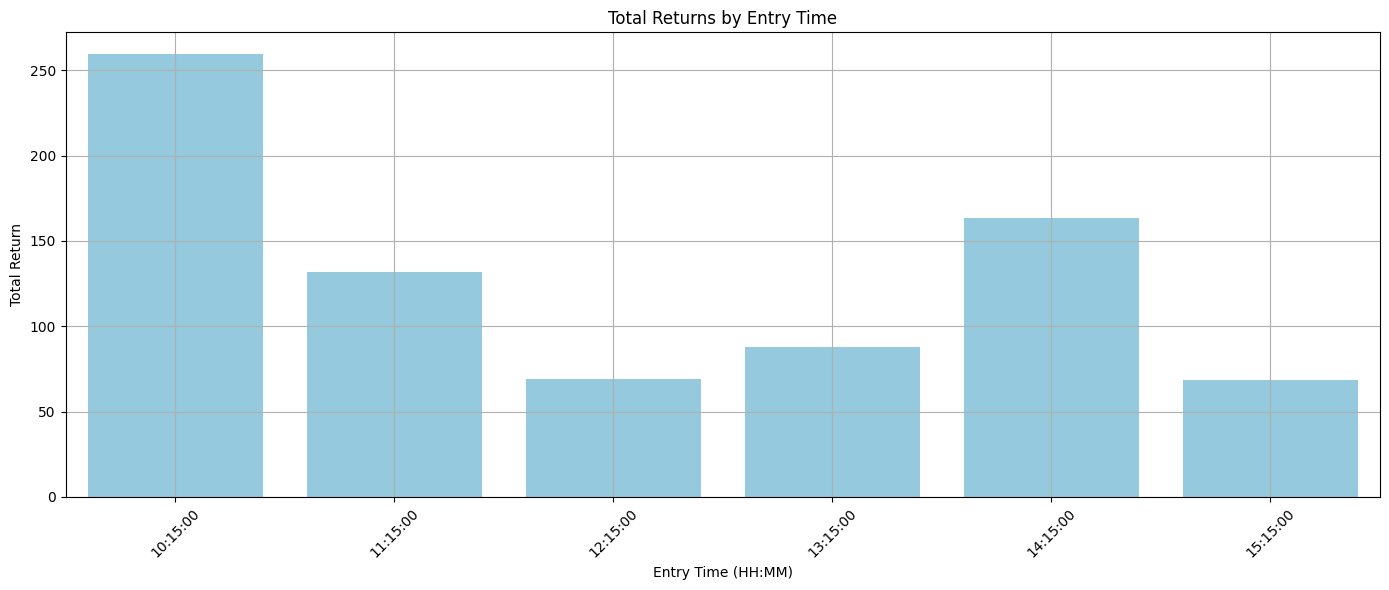

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = tradebook_buy_side.copy()  # your DataFrame

# Step 1: Convert time to string format (HH:MM) for better x-axis display
df['entry_time_str'] = df['Entry Time'].dt.time.apply(lambda t: t.strftime('%H:%M:%S'))

# Step 2: Group by time and sum the returns
agg_df = df.groupby('entry_time_str')['ROI%'].sum().reset_index()

# Step 3: Plot the summed returns by time
plt.figure(figsize=(14, 6))
sns.barplot(x='entry_time_str', y='ROI%', data=agg_df, color='skyblue')
plt.xticks(rotation=45)
plt.title('Total Returns by Entry Time')
plt.xlabel('Entry Time (HH:MM)')
plt.ylabel('Total Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
tradebook_buy_side.to_csv(f'{INDEX_}_mtrend.csv', index=False)

In [57]:
# bnf1 = bnf1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})

In [259]:
stats_dict = {}

for i in range(41, 50):
    for j in range(11, 20):
            variation = f'SMA: {i}, TMA: {j}'
            print(variation)
            signals_df1 = generate_signals1(bnf1, i, j, 1)
            new_tb = execute(signals_df1)
            stats = generate_stats(new_tb, variation)
            for overall_roi_dd_ratio, stats_df in stats.items():
                if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 15:
                    stats_dict[overall_roi_dd_ratio] = stats_df
                    print(stats_df.to_string())

SMA: 41, TMA: 11
SMA: 41, TMA: 12
SMA: 41, TMA: 13
SMA: 41, TMA: 14
SMA: 41, TMA: 15
SMA: 41, TMA: 16
SMA: 41, TMA: 17
SMA: 41, TMA: 18
SMA: 41, TMA: 19
SMA: 42, TMA: 11
SMA: 42, TMA: 12
SMA: 42, TMA: 13
SMA: 42, TMA: 14
SMA: 42, TMA: 15
SMA: 42, TMA: 16
SMA: 42, TMA: 17
SMA: 42, TMA: 18
SMA: 42, TMA: 19
SMA: 43, TMA: 11
SMA: 43, TMA: 12
SMA: 43, TMA: 13
SMA: 43, TMA: 14
SMA: 43, TMA: 15
SMA: 43, TMA: 16
SMA: 43, TMA: 17
SMA: 43, TMA: 18
SMA: 43, TMA: 19
SMA: 44, TMA: 11
SMA: 44, TMA: 12
SMA: 44, TMA: 13
SMA: 44, TMA: 14
SMA: 44, TMA: 15
SMA: 44, TMA: 16
SMA: 44, TMA: 17
SMA: 44, TMA: 18
SMA: 44, TMA: 19
SMA: 45, TMA: 11
        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio         Variation
2019      84.2888           98  28.5714                8.6608             -2.2602     -22.4306       3.7578  SMA: 45, TMA: 11
2020     214.1564           93  32.2581               13.8710             -3.2059     -34.2640       6.2502  SMA: 45, T

In [260]:
sorted_stats = {k: v for k, v in sorted(stats_dict.items(), key=lambda item: item[0], reverse=True)}

In [261]:
sorted_stats

{20.651903346447934:         Total ROI Total Trades Win Rate Avg Profit% per Trade  \
 2019      75.3356           90  28.8889                8.7580   
 2020     270.9227           83  34.9398               15.0935   
 2021     138.8885           93  35.4839                8.9262   
 2022      89.2523           93  34.4086                7.8499   
 2023     121.6089           91  30.7692                8.6523   
 2024      42.9116           85  30.5882                6.9048   
 2025      25.7974           18  33.3333               10.4710   
 Overall  764.7171          553  33.2263                8.9355   
 
         Avg Loss% per Trade Max Drawdown ROI/DD Ratio         Variation  
 2019                -2.3808     -21.8304       3.4509  SMA: 45, TMA: 14  
 2020                -3.0887     -34.1072       7.9433  SMA: 45, TMA: 14  
 2021                -2.5946     -36.3802       3.8177  SMA: 45, TMA: 14  
 2022                -2.6548     -27.0991       3.2936  SMA: 45, TMA: 14  
 2023    

# MTrend BNF

In [36]:
# new_tb.to_csv('BNF Mtrend New.csv', index=False)

In [139]:
# Positional Sell Side


def execute_sell_side(df):
    portfolio_value = 7500000
    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    remark = ""
    is_trailing_active = False
    previous_trade_exit_time = None

    print(lev_, slippage_, portfolio_value)
    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_moving_average_price = df.iloc[i]["MA10"]

        if not in_trade:
            if df.iloc[i]["Sell_Signal"] == 1:
                if not already_signal_exists:
                    # Fresh Sell Signal
                    # print(df.iloc[i])
                    # print('Fresh Short Sell Signal')
                    signal_entry_price = current_candle_low
                    signal_initial_sl = current_candle_high
                    signal_creation_time = df.iloc[i]["datetime"]
                    already_signal_exists = True

                    # if (signal_initial_sl - signal_entry_price > 400):
                    #     # Skip Signal Candle Due To Big Size
                    #     already_signal_exists = False
                    #     signal_entry_price = 100000
                    #     signal_initial_sl = 0

                else:
                    if current_candle_open < signal_entry_price:
                        # Gap Down Outside, SKIP trade
                        # print('Signal Entry Price' , signal_entry_price)
                        # print(df.iloc[i])
                        # print('Gap Outside, Skip Trade')
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0
                    elif current_candle_low > signal_entry_price:
                        # Better Candle
                        
                        # print(df.iloc[i])
                        # print('Better Candle')
                        signal_entry_price = current_candle_low
                        signal_initial_sl = current_candle_high
                        signal_creation_time = df.iloc[i]["datetime"]

                        # if (signal_initial_sl - signal_entry_price > 400):
                        #     # Skip Signal Candle Due To Big Size
                        #     already_signal_exists = False
                        #     signal_entry_price = 100000
                        #     signal_initial_sl = 0

                    elif current_candle_low < signal_entry_price:
                        # Entry Triggered
                        
                        # print(df.iloc[i])
                        # print('Entry Triggered')
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
            else:
                if df.iloc[i - 1]["Sell_Signal"] == 1:
                    # Considering the forward bias condition as well now
                    signal_entry_price = df.iloc[i - 1]["l"]
                    signal_initial_sl = df.iloc[i - 1]["h"]
                    signal_creation_time = df.iloc[i - 1]["datetime"]
                    already_signal_exists = True

                    if current_candle_low < signal_entry_price:
                        if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
                            in_trade = True
                            entry_time = df.iloc[i]["datetime"]
                            entry_price = signal_entry_price
                            points = 0
                    else:
                        # Discard Existing Signal
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_high < current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # Initial SL Hit
                    
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

                elif current_candle_close >= trade_final_sl:
                    # TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    remark = "TSL Hit"

            elif is_trailing_active:
                trade_final_sl = min(trade_initial_sl, current_moving_average_price)

                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # if trade_initial_sl <= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close >= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                qty = int(round((portfolio_value * lev_ / entry_price) / lot_size_) * lot_size_)
                slippage = slippage_ * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                previous_trade_exit_time = exit_time
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "SHORT",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": lev_,
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                # print(trade)
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [38]:
# bnf_pandas = pd.read_csv('../data/midcp_1hr_tv_new.csv')

In [39]:
# bnf_pandas.head()

In [40]:
# # If Stocks Data ...
# bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["time"])
# bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
# bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
# bnf_pandas.drop(columns=["time"], inplace=True)
# # bnf_pandas

In [41]:
# bnf = pl.DataFrame(bnf_pandas)
# bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")


In [42]:
# data = pl.DataFrame(data)
# data = data.with_columns([
#     pl.col("datetime").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
# ])

In [140]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2022, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2022, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = variation
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation
    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio : stats_df8}

In [44]:
# targets = [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 100]
# time_frames = ["3m", "5m", "10m", "15m", "30m", "60m"]
# num_candles = [1, 2, 3, 4, 5]
# for i in range(5, 81, 5):
#     for j in range(5, 81, 5):
#         for k in targets:
#             for tf in time_frames:
#                 for candles in num_candles:
#                     if tf == "10m":
#                         offset = "5m"
#                     elif tf == "30m" or tf == "60m":
#                         offset = "15m"
#                     else:
#                         offset = "0m"
#                     variation = f"SMA: {i}, TMA: {j}, Target: {k}R, TF: {tf}, Candles: {candles}"
#                     print(variation)
#                     data_w_signals = (resample(data, tf, offset)).to_pandas()
#                     data_w_signals = generate_signals2(data_w_signals, i, j, candles)
#                     data_w_signals2 = data_w_signals.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})
#                     sell_tb = execute_sell_side(data_w_signals2)
#                     stats = generate_stats(sell_tb, variation)
#                     for overall_roi_dd_ratio, stats_df in stats.items():
#                         if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 3:
#                             print(stats_df.to_string())
#                             stats_dictionary[overall_roi_dd_ratio] = stats_df

In [ ]:
# tradebook_sell_side

In [45]:
# bnf_pandas.head()

In [180]:
signals_df1 = generate_signals2(bnf1, 50, 49, 5)
tradebook_sell_side = execute_sell_side(signals_df1)

3 0.0005 7500000


In [182]:
# tradebook_sell_side = tradebook_sell_side[154:]
tradebook_sell_side

Signal Generated At Trade Type          Entry Time  Entry Price  \
0  2022-01-21 10:15:00      SHORT 2022-01-21 11:15:00    7616.7500   
1  2022-01-28 11:15:00      SHORT 2022-01-28 12:15:00    7548.7000   
2  2022-01-31 13:15:00      SHORT 2022-01-31 14:15:00    7514.1500   
3  2022-02-01 10:15:00      SHORT 2022-02-01 11:15:00    7560.3500   
4  2022-02-09 15:15:00      SHORT 2022-02-10 09:15:00    7505.7000   
5  2022-02-10 12:15:00      SHORT 2022-02-10 13:15:00    7548.0500   
6  2022-03-03 11:15:00      SHORT 2022-03-03 12:15:00    6978.0500   
7  2022-03-11 12:15:00      SHORT 2022-03-11 13:15:00    6885.2000   
8  2022-03-11 15:15:00      SHORT 2022-03-14 09:15:00    6930.3500   
9  2022-04-19 11:15:00      SHORT 2022-04-19 12:15:00    7451.6500   
10 2022-04-29 14:15:00      SHORT 2022-04-29 15:15:00    7225.3500   
11 2022-05-18 10:15:00      SHORT 2022-05-18 11:15:00    6743.3000   
12 2022-05-27 09:15:00      SHORT 2022-05-27 10:15:00    6617.8500   
13 2022-06-10 10:15:00      SHORT 2022-06-10 11:15:00    6635.7000   
14 2022-08-29 13:15:00      SHORT 2022-08-29 14:15:00    7257.1500   
15 2022-08-30 11:15:00      SHORT 2022-08-30 12:15:00    7371.0000   
16 2022-09-19 10:15:00      SHORT 2022-09-19 11:15:00    7395.0000   
17 2022-09-20 10:15:00      SHORT 2022-09-20 11:15:00    7537.4000   
18 2022-09-30 15:15:00      SHORT 2022-10-03 09:15:00    7195.2000   
19 2022-10-18 10:15:00      SHORT 2022-10-18 11:15:00    7317.2000   
20 2022-11-11 09:15:00      SHORT 2022-11-11 10:15:00    7369.2000   
21 2022-11-23 12:15:00      SHORT 2022-11-23 13:15:00    7254.5500   
22 2022-11-24 11:15:00      SHORT 2022-11-24 12:15:00    7263.7500   
23 2022-12-12 15:15:00      SHORT 2022-12-13 09:15:00    7411.0000   
24 2022-12-13 13:15:00      SHORT 2022-12-13 14:15:00    7405.5500   
25 2022-12-16 12:15:00      SHORT 2022-12-16 13:15:00    7321.4500   
26 2022-12-21 11:15:00      SHORT 2022-12-21 12:15:00    7352.5500   
27 2022-12-28 11:15:00      SHORT 2022-12-28 12:15:00    7158.1000   
28 2022-12-30 10:15:00      SHORT 2022-12-30 11:15:00    7195.4000   
29 2022-12-30 13:15:00      SHORT 2022-12-30 14:15:00    7191.4500   
30 2023-01-10 15:15:00      SHORT 2023-01-11 09:15:00    7129.9000   
31 2023-01-11 10:15:00      SHORT 2023-01-11 11:15:00    7127.7500   
32 2023-01-23 13:15:00      SHORT 2023-01-23 14:15:00    7039.0000   
33 2023-01-24 09:15:00      SHORT 2023-01-24 10:15:00    7040.0000   
34 2023-02-02 11:15:00      SHORT 2023-02-02 12:15:00    6916.4000   
35 2023-02-02 15:15:00      SHORT 2023-02-03 09:15:00    6935.0500   
36 2023-02-03 15:15:00      SHORT 2023-02-06 09:15:00    6946.3500   
37 2023-02-20 12:15:00      SHORT 2023-02-20 13:15:00    7016.1000   
38 2023-02-20 14:15:00      SHORT 2023-02-20 15:15:00    6998.9500   
39 2023-02-21 11:15:00      SHORT 2023-02-21 12:15:00    7002.6500   
40 2023-03-01 15:15:00      SHORT 2023-03-02 09:15:00    6870.0500   
41 2023-03-02 11:15:00      SHORT 2023-03-02 12:15:00    6878.0500   
42 2023-03-13 15:15:00      SHORT 2023-03-14 09:15:00    6764.9500   
43 2023-03-15 11:15:00      SHORT 2023-03-15 12:15:00    6770.1500   
44 2023-03-17 09:15:00      SHORT 2023-03-17 10:15:00    6816.6500   
45 2023-03-22 12:15:00      SHORT 2023-03-22 13:15:00    6812.0000   
46 2023-09-21 15:15:00      SHORT 2023-09-22 09:15:00    9067.1500   
47 2023-09-22 09:15:00      SHORT 2023-09-28 14:15:00    9030.2000   
48 2023-09-29 13:15:00      SHORT 2023-09-29 14:15:00    9112.7500   
49 2023-10-09 11:15:00      SHORT 2023-10-09 12:15:00    9019.2500   
50 2023-10-09 14:15:00      SHORT 2023-10-09 15:15:00    9019.6500   
51 2023-10-19 14:15:00      SHORT 2023-10-19 15:15:00    9058.8000   
52 2023-11-02 10:15:00      SHORT 2023-11-02 11:15:00    8814.0000   
53 2024-01-18 13:15:00      SHORT 2024-01-18 14:15:00   10403.4500   
54 2024-01-23 15:15:00      SHORT 2024-01-24 09:15:00   10333.6000   
55 2024-01-24 10:15:00      SHORT 2024-01-24 11:15:00   10444.4000   
56 2024-01-24

In [177]:
st = generate_stats(tradebook_sell_side, '///')

In [178]:
final_stats = pd.DataFrame()
for x, y in st.items():
    final_stats = pd.DataFrame(y)

In [166]:
final_stats

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2022       0.0000            0      NaN                   NaN   
2023       0.0000            0      NaN                   NaN   
2024     -33.9828           27   7.4074                1.3250   
Overall  -33.9828           27   7.4074                1.3250   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation  
2022                    NaN          NaN          NaN       ///  
2023                    NaN          NaN          NaN       ///  
2024                -1.4653     -33.1398      -1.0254       ///  
Overall             -1.4653     -33.1398      -1.0254       ///

# Stats from May 2024 to Oct 2024

In [179]:
final_stats

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2022      79.8412           30  36.6667                9.7085   
2023       6.4825           23  30.4348                3.6107   
2024     -15.5394           21   9.5238                4.7988   
Overall   70.7843           74  27.0270                7.0833   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation  
2022                -1.4186      -6.4194      12.4374       ///  
2023                -1.1745      -6.7692       0.9576       ///  
2024                -1.3230     -14.0853      -1.1032       ///  
Overall             -1.3126     -16.5891       4.2669       ///

# Initial Stats till May 2024

In [176]:
tradebook_sell_side = tradebook_sell_side[:74]
# tradebook_sell_side

In [183]:
tradebook_sell_side

Signal Generated At Trade Type          Entry Time  Entry Price  \
0  2022-01-21 10:15:00      SHORT 2022-01-21 11:15:00    7616.7500   
1  2022-01-28 11:15:00      SHORT 2022-01-28 12:15:00    7548.7000   
2  2022-01-31 13:15:00      SHORT 2022-01-31 14:15:00    7514.1500   
3  2022-02-01 10:15:00      SHORT 2022-02-01 11:15:00    7560.3500   
4  2022-02-09 15:15:00      SHORT 2022-02-10 09:15:00    7505.7000   
5  2022-02-10 12:15:00      SHORT 2022-02-10 13:15:00    7548.0500   
6  2022-03-03 11:15:00      SHORT 2022-03-03 12:15:00    6978.0500   
7  2022-03-11 12:15:00      SHORT 2022-03-11 13:15:00    6885.2000   
8  2022-03-11 15:15:00      SHORT 2022-03-14 09:15:00    6930.3500   
9  2022-04-19 11:15:00      SHORT 2022-04-19 12:15:00    7451.6500   
10 2022-04-29 14:15:00      SHORT 2022-04-29 15:15:00    7225.3500   
11 2022-05-18 10:15:00      SHORT 2022-05-18 11:15:00    6743.3000   
12 2022-05-27 09:15:00      SHORT 2022-05-27 10:15:00    6617.8500   
13 2022-06-10 10:15:00      SHORT 2022-06-10 11:15:00    6635.7000   
14 2022-08-29 13:15:00      SHORT 2022-08-29 14:15:00    7257.1500   
15 2022-08-30 11:15:00      SHORT 2022-08-30 12:15:00    7371.0000   
16 2022-09-19 10:15:00      SHORT 2022-09-19 11:15:00    7395.0000   
17 2022-09-20 10:15:00      SHORT 2022-09-20 11:15:00    7537.4000   
18 2022-09-30 15:15:00      SHORT 2022-10-03 09:15:00    7195.2000   
19 2022-10-18 10:15:00      SHORT 2022-10-18 11:15:00    7317.2000   
20 2022-11-11 09:15:00      SHORT 2022-11-11 10:15:00    7369.2000   
21 2022-11-23 12:15:00      SHORT 2022-11-23 13:15:00    7254.5500   
22 2022-11-24 11:15:00      SHORT 2022-11-24 12:15:00    7263.7500   
23 2022-12-12 15:15:00      SHORT 2022-12-13 09:15:00    7411.0000   
24 2022-12-13 13:15:00      SHORT 2022-12-13 14:15:00    7405.5500   
25 2022-12-16 12:15:00      SHORT 2022-12-16 13:15:00    7321.4500   
26 2022-12-21 11:15:00      SHORT 2022-12-21 12:15:00    7352.5500   
27 2022-12-28 11:15:00      SHORT 2022-12-28 12:15:00    7158.1000   
28 2022-12-30 10:15:00      SHORT 2022-12-30 11:15:00    7195.4000   
29 2022-12-30 13:15:00      SHORT 2022-12-30 14:15:00    7191.4500   
30 2023-01-10 15:15:00      SHORT 2023-01-11 09:15:00    7129.9000   
31 2023-01-11 10:15:00      SHORT 2023-01-11 11:15:00    7127.7500   
32 2023-01-23 13:15:00      SHORT 2023-01-23 14:15:00    7039.0000   
33 2023-01-24 09:15:00      SHORT 2023-01-24 10:15:00    7040.0000   
34 2023-02-02 11:15:00      SHORT 2023-02-02 12:15:00    6916.4000   
35 2023-02-02 15:15:00      SHORT 2023-02-03 09:15:00    6935.0500   
36 2023-02-03 15:15:00      SHORT 2023-02-06 09:15:00    6946.3500   
37 2023-02-20 12:15:00      SHORT 2023-02-20 13:15:00    7016.1000   
38 2023-02-20 14:15:00      SHORT 2023-02-20 15:15:00    6998.9500   
39 2023-02-21 11:15:00      SHORT 2023-02-21 12:15:00    7002.6500   
40 2023-03-01 15:15:00      SHORT 2023-03-02 09:15:00    6870.0500   
41 2023-03-02 11:15:00      SHORT 2023-03-02 12:15:00    6878.0500   
42 2023-03-13 15:15:00      SHORT 2023-03-14 09:15:00    6764.9500   
43 2023-03-15 11:15:00      SHORT 2023-03-15 12:15:00    6770.1500   
44 2023-03-17 09:15:00      SHORT 2023-03-17 10:15:00    6816.6500   
45 2023-03-22 12:15:00      SHORT 2023-03-22 13:15:00    6812.0000   
46 2023-09-21 15:15:00      SHORT 2023-09-22 09:15:00    9067.1500   
47 2023-09-22 09:15:00      SHORT 2023-09-28 14:15:00    9030.2000   
48 2023-09-29 13:15:00      SHORT 2023-09-29 14:15:00    9112.7500   
49 2023-10-09 11:15:00      SHORT 2023-10-09 12:15:00    9019.2500   
50 2023-10-09 14:15:00      SHORT 2023-10-09 15:15:00    9019.6500   
51 2023-10-19 14:15:00      SHORT 2023-10-19 15:15:00    9058.8000   
52 2023-11-02 10:15:00      SHORT 2023-11-02 11:15:00    8814.0000   
53 2024-01-18 13:15:00      SHORT 2024-01-18 14:15:00   10403.4500   
54 2024-01-23 15:15:00      SHORT 2024-01-24 09:15:00   10333.6000   
55 2024-01-24 10:15:00      SHORT 2024-01-24 11:15:00   10444.4000   
56 2024-01-24

In [184]:
tradebook_sell_side.to_csv('All midcp short trades MTREND.csv')